In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from gtfparse import read_gtf
from matplotlib_venn import venn3, venn3_circles, venn2, venn2_circles
import matplotlib.lines as mlines
from scipy.stats import ttest_1samp, mannwhitneyu, wilcoxon
from statsmodels.stats.multitest import fdrcorrection
import bioframe
import warnings
warnings.filterwarnings('ignore')

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## DEGs

In [3]:
# Read GTF with gene annotation
genes = read_gtf('/DATA/users/magnitov/tacl/genome/gencode.v44.annotation.gtf')
genes = genes[genes['feature'] == 'gene']
genes = genes[['seqname', 'start', 'end', 'strand', 'gene_id', 'gene_type', 'gene_name']]
genes.columns = ['chrom', 'start', 'end', 'strand', 'gene_id', 'gene_type', 'gene_name']
genes.head()

INFO:root:Extracted GTF attributes: ['gene_id', 'gene_type', 'gene_name', 'level', 'tag', 'transcript_id', 'transcript_type', 'transcript_name', 'transcript_support_level', 'havana_transcript', 'exon_number', 'exon_id', 'hgnc_id', 'havana_gene', 'ont', 'protein_id', 'ccdsid', 'artif_dupl']


,chrom,start,end,strand,gene_id,gene_type,gene_name
0,chr1,11869,14409,+,ENSG00000290825.1,lncRNA,DDX11L2
5,chr1,12010,13670,+,ENSG00000223972.6,transcribed_unprocessed_pseudogene,DDX11L1
13,chr1,14404,29570,-,ENSG00000227232.5,unprocessed_pseudogene,WASH7P
26,chr1,17369,17436,-,ENSG00000278267.1,miRNA,MIR6859-1
29,chr1,29554,31109,+,ENSG00000243485.5,lncRNA,MIR1302-2HG


#### Not expressed genes

In [4]:
degs = pd.read_csv('/DATA/users/magnitov/tacl/bruseq/degs/degs_TMAU2_DOX_vs_NT_DESeq2_ruiqi.csv', sep = '\s+', header = 0)
degs['gene_id'] = degs.index

non_expressed = genes.merge(degs, on = 'gene_id', how = 'left', suffixes = ('', '_deg'))
non_expressed = non_expressed[non_expressed['baseMean'].isna()]
columns_to_save = ['chrom', 'start', 'end', 'gene_name', 'gene_id', 'strand', 'gene_type']
non_expressed = non_expressed[columns_to_save]

print(len(non_expressed))
non_expressed.to_csv('/DATA/users/magnitov/tacl/bruseq/degs/not_expressed.bed', header = 1, index = 0, sep = '\t')

45491


#### T-MAU2 DOX vs NT

In [5]:
degs_tmau2_dox_vs_nt = pd.read_csv('/DATA/users/magnitov/tacl/bruseq/degs/degs_TMAU2_DOX_vs_NT_DESeq2_ruiqi.csv', sep = '\s+', header = 0)
degs_tmau2_dox_vs_nt['gene_id'] = degs_tmau2_dox_vs_nt.index
degs_tmau2_dox_vs_nt.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_id
ENSG00000227232.5,27.445432,-0.163284,0.352955,-0.462620,0.643637,NaN,ENSG00000227232.5
ENSG00000279457.4,60.546671,0.047120,0.244090,0.193044,0.846924,NaN,ENSG00000279457.4
ENSG00000228463.10,36.304334,0.065144,0.306624,0.212455,0.831752,NaN,ENSG00000228463.10
ENSG00000230021.10,677.045771,-0.031524,0.075828,-0.415733,0.677606,NaN,ENSG00000230021.10
ENSG00000225972.1,25.299524,-0.104370,0.388600,-0.268580,0.788253,NaN,ENSG00000225972.1


In [6]:
degs_tmau2_dox_vs_nt = degs_tmau2_dox_vs_nt.merge(genes, on = 'gene_id')

columns_to_save = ['chrom', 'start', 'end', 'gene_name', 'gene_id', 'strand', 'gene_type', 'log2FoldChange', 'baseMean', 'pvalue', 'padj']
degs_tmau2_dox_vs_nt = degs_tmau2_dox_vs_nt[columns_to_save]

degs_tmau2_dox_vs_nt.sort_values('padj').head(10)

,chrom,start,end,gene_name,gene_id,strand,gene_type,log2FoldChange,baseMean,pvalue,padj
8561,chr10,61901684,62096944,ARID5B,ENSG00000150347.17,+,protein_coding,1.121399,2133.526906,9.699557e-87,5.041830e-83
4251,chr4,138164097,138242349,SLC7A11,ENSG00000151012.13,-,protein_coding,0.607333,4045.559539,5.568808e-40,1.447333e-36
7497,chr8,115408496,115809673,TRPS1,ENSG00000104447.13,-,protein_coding,0.544046,10854.653012,1.376351e-32,2.384757e-29
17084,chrX,132369320,132489968,MBNL3,ENSG00000076770.16,-,protein_coding,0.684560,1218.374076,1.600421e-30,2.079747e-27
14340,chr18,56597209,56651600,TXNL1,ENSG00000091164.13,-,protein_coding,0.705235,1726.085470,2.144619e-26,2.229546e-23
14301,chr18,47808957,47931146,SMAD2,ENSG00000175387.16,-,protein_coding,0.437310,6245.998749,7.493263e-26,6.491664e-23
14397,chr18,76357682,76495242,ZNF516,ENSG00000101493.11,-,protein_coding,0.577109,1919.199954,1.969719e-22,1.462657e-19
4516,chr5,34164698,34244796,ENSG00000290548,ENSG00000290548.1,-,lncRNA,0.436901,2080.302008,1.300893e-15,8.452552e-13
910,chr1,119648411,119744218,PHGDH,ENSG00000092621.13,+,protein_coding,0.432598,1548.111847,1.039994e-14,6.006545e-12
7905,chr9,78297125,78330093,PSAT1,ENSG00000135069.14,+,protein_coding,0.396688,2522.757078,2.336157e-13,1.214334e-10


In [9]:
degs_tmau2_dox_vs_nt_up = degs_tmau2_dox_vs_nt[(degs_tmau2_dox_vs_nt['padj'] < 0.05) & (degs_tmau2_dox_vs_nt['log2FoldChange'] > 1)]
degs_tmau2_dox_vs_nt_down = degs_tmau2_dox_vs_nt[(degs_tmau2_dox_vs_nt['padj'] < 0.05) & (degs_tmau2_dox_vs_nt['log2FoldChange'] < -1)]
degs_tmau2_dox_vs_nt_stable = degs_tmau2_dox_vs_nt[~degs_tmau2_dox_vs_nt['gene_id'].isin([x for x in degs_tmau2_dox_vs_nt['gene_id'].values \
                                          if x in degs_tmau2_dox_vs_nt_down['gene_id'].values or x in degs_tmau2_dox_vs_nt_up['gene_id'].values])]

print('Up-regulated:', len(degs_tmau2_dox_vs_nt_up))
print('Down-regulated:', len(degs_tmau2_dox_vs_nt_down))
print('No change:', len(degs_tmau2_dox_vs_nt_stable))
print('Low expression:', len(genes) - len(degs_tmau2_dox_vs_nt))

Up-regulated: 1
Down-regulated: 0
No change: 17208
Low expression: 45491


#### T-mCherry DOX vs NT

In [12]:
degs_tmcherry_dox_vs_nt = pd.read_csv('/DATA/users/magnitov/tacl/bruseq/degs/degs_TmCherry_DOX_vs_NT_DESeq2_ruiqi.csv', sep = '\s+', header = 0)
degs_tmcherry_dox_vs_nt['gene_id'] = degs_tmcherry_dox_vs_nt.index
degs_tmcherry_dox_vs_nt.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_id
ENSG00000227232.5,27.445432,-0.901115,0.642506,-1.402501,0.160766,NaN,ENSG00000227232.5
ENSG00000279457.4,60.546671,0.074073,0.370410,0.199976,0.841499,NaN,ENSG00000279457.4
ENSG00000228463.10,36.304334,-1.459525,0.543783,-2.684021,0.007274,NaN,ENSG00000228463.10
ENSG00000230021.10,677.045771,0.049317,0.121549,0.405733,0.684939,0.875027,ENSG00000230021.10
ENSG00000225972.1,25.299524,0.033386,0.660418,0.050553,0.959682,NaN,ENSG00000225972.1


In [13]:
degs_tmcherry_dox_vs_nt = degs_tmcherry_dox_vs_nt.merge(genes, on = 'gene_id')

columns_to_save = ['chrom', 'start', 'end', 'gene_name', 'gene_id', 'strand', 'gene_type', 'log2FoldChange', 'baseMean', 'pvalue', 'padj']
degs_tmcherry_dox_vs_nt = degs_tmcherry_dox_vs_nt[columns_to_save]

degs_tmcherry_dox_vs_nt.sort_values('padj').head()

,chrom,start,end,gene_name,gene_id,strand,gene_type,log2FoldChange,baseMean,pvalue,padj
4251,chr4,138164097,138242349,SLC7A11,ENSG00000151012.13,-,protein_coding,0.739136,4045.559539,2.081676e-26,1.637655e-22
14340,chr18,56597209,56651600,TXNL1,ENSG00000091164.13,-,protein_coding,1.067759,1726.085470,5.155358e-26,2.027860e-22
14397,chr18,76357682,76495242,ZNF516,ENSG00000101493.11,-,protein_coding,0.927054,1919.199954,1.488715e-23,3.903906e-20
8561,chr10,61901684,62096944,ARID5B,ENSG00000150347.17,+,protein_coding,0.687244,2133.526906,9.714201e-16,1.910541e-12
14301,chr18,47808957,47931146,SMAD2,ENSG00000175387.16,-,protein_coding,0.459835,6245.998749,4.293322e-13,6.755113e-10


In [15]:
degs_tmcherry_dox_vs_nt.sort_values('padj').to_csv('/DATA/users/magnitov/tacl/BrUseq_Cherry-OFF_vs_Cherry-ON_deseq2.tsv', header = 1, index = 0, sep = '\t')

In [13]:
degs_tmcherry_dox_vs_nt_up = degs_tmcherry_dox_vs_nt[(degs_tmcherry_dox_vs_nt['padj'] < 0.05) & (degs_tmcherry_dox_vs_nt['log2FoldChange'] > 1)]
degs_tmcherry_dox_vs_nt_down = degs_tmcherry_dox_vs_nt[(degs_tmcherry_dox_vs_nt['padj'] < 0.05) & (degs_tmcherry_dox_vs_nt['log2FoldChange'] < -1)]
degs_tmcherry_dox_vs_nt_stable = degs_tmcherry_dox_vs_nt[~degs_tmcherry_dox_vs_nt['gene_id'].isin([x for x in degs_tmcherry_dox_vs_nt['gene_id'].values \
                                          if x in degs_tmcherry_dox_vs_nt_down['gene_id'].values or x in degs_tmcherry_dox_vs_nt_up['gene_id'].values])]

print('Up-regulated:', len(degs_tmcherry_dox_vs_nt_up))
print('Down-regulated:', len(degs_tmcherry_dox_vs_nt_down))
print('No change:', len(degs_tmcherry_dox_vs_nt_stable))
print('Low expression:', len(genes) - len(degs_tmcherry_dox_vs_nt))

Up-regulated: 1
Down-regulated: 0
No change: 17208
Low expression: 45491


## Volcano plots

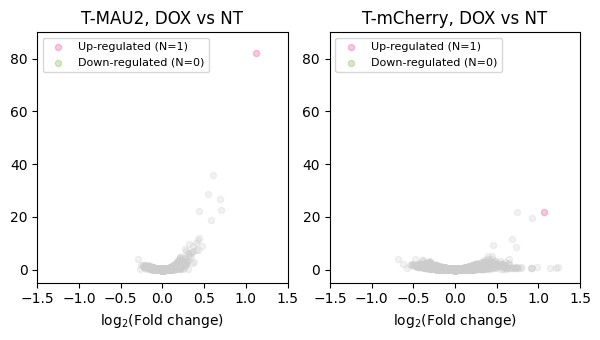

In [12]:
plt.figure(figsize = (6, 3.5))

plt.subplot(121)
plt.title('T-MAU2, DOX vs NT', fontsize = 12)
plt.scatter(degs_tmau2_dox_vs_nt_stable['log2FoldChange'], -np.log10(degs_tmau2_dox_vs_nt_stable['padj']), 
            color = '#CCCCCC', label = '_nolegend_', alpha = 0.25, s = 20)
plt.scatter(degs_tmau2_dox_vs_nt_up['log2FoldChange'], -np.log10(degs_tmau2_dox_vs_nt_up['padj']), 
            color = '#E72A8A', label = 'Up-regulated (N=' + str(len(degs_tmau2_dox_vs_nt_up)) + ')', alpha = 0.25, s = 20)
plt.scatter(degs_tmau2_dox_vs_nt_down['log2FoldChange'], -np.log10(degs_tmau2_dox_vs_nt_down['padj']), 
            color = '#66A61E', label = 'Down-regulated (N=' + str(len(degs_tmau2_dox_vs_nt_down)) + ')', alpha = 0.25, s = 20)

plt.xlabel('log$_2$(Fold change)', fontsize = 10)
plt.xlim((-1.5, 1.5))
plt.ylim((-5, 90))
plt.legend(loc = 'upper left', fontsize = 8)

plt.subplot(122)
plt.title('T-mCherry, DOX vs NT', fontsize = 12)
plt.scatter(degs_tmcherry_dox_vs_nt_stable['log2FoldChange'], -np.log10(degs_tmcherry_dox_vs_nt_stable['padj']), 
            color = '#CCCCCC', label = '_nolegend_', alpha = 0.25, s = 20)
plt.scatter(degs_tmcherry_dox_vs_nt_up['log2FoldChange'], -np.log10(degs_tmcherry_dox_vs_nt_up['padj']), 
            color = '#E72A8A', label = 'Up-regulated (N=' + str(len(degs_tmcherry_dox_vs_nt_up)) + ')', alpha = 0.25, s = 20)
plt.scatter(degs_tmcherry_dox_vs_nt_down['log2FoldChange'], -np.log10(degs_tmcherry_dox_vs_nt_down['padj']), 
            color = '#66A61E', label = 'Down-regulated (N=' + str(len(degs_tmcherry_dox_vs_nt_down)) + ')', alpha = 0.25, s = 20)

plt.xlabel('log$_2$(Fold change)', fontsize = 10)
plt.xlim((-1.5, 1.5))
plt.ylim((-5, 90))
plt.legend(loc = 'upper left', fontsize = 8)

plt.tight_layout()
plt.show()

## MA plots

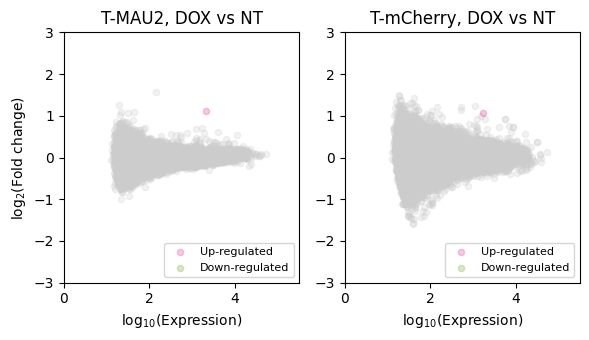

In [13]:
plt.figure(figsize = (6, 3.5))

plt.subplot(121)
plt.title('T-MAU2, DOX vs NT', fontsize = 12)
plt.scatter(np.log10(degs_tmau2_dox_vs_nt_stable['baseMean']), degs_tmau2_dox_vs_nt_stable['log2FoldChange'], 
            color = '#CCCCCC', label = '_nolegend_', alpha = 0.25, s = 20)
plt.scatter(np.log10(degs_tmau2_dox_vs_nt_up['baseMean']), degs_tmau2_dox_vs_nt_up['log2FoldChange'], 
            color = '#E72A8A', label = 'Up-regulated', alpha = 0.25, s = 20)
plt.scatter(np.log10(degs_tmau2_dox_vs_nt_down['baseMean']), degs_tmau2_dox_vs_nt_down['log2FoldChange'], 
            color = '#66A61E', label = 'Down-regulated', alpha = 0.25, s = 20)

plt.xlabel(r'log$_{10}$(Expression)', fontsize = 10)
plt.ylabel('log$_2$(Fold change)', fontsize = 10)
plt.ylim((-3, 3))
plt.xlim((0, 5.5))
plt.legend(loc = 'lower right', fontsize = 8)

plt.subplot(122)
plt.title('T-mCherry, DOX vs NT', fontsize = 12)
plt.scatter(np.log10(degs_tmcherry_dox_vs_nt_stable['baseMean']), degs_tmcherry_dox_vs_nt_stable['log2FoldChange'], 
            color = '#CCCCCC', label = '_nolegend_', alpha = 0.25, s = 20)
plt.scatter(np.log10(degs_tmcherry_dox_vs_nt_up['baseMean']), degs_tmcherry_dox_vs_nt_up['log2FoldChange'], 
            color = '#E72A8A', label = 'Up-regulated', alpha = 0.25, s = 20)
plt.scatter(np.log10(degs_tmcherry_dox_vs_nt_down['baseMean']), degs_tmcherry_dox_vs_nt_down['log2FoldChange'], 
            color = '#66A61E', label = 'Down-regulated', alpha = 0.25, s = 20)

plt.xlabel(r'log$_{10}$(Expression)', fontsize = 10)
plt.ylim((-3, 3))
plt.xlim((0, 5.5))
plt.legend(loc = 'lower right', fontsize = 8)

plt.tight_layout()
plt.show()

## Overlap with TACL domains

In [15]:
tacl_domains = pd.read_csv('/DATA/users/magnitov/tacl/4c/TACL_domains_HMM.bed', sep = '\t', header = None)
tacl_domains.columns = ['chrom', 'start', 'end', 'teto_id']
tacl_domains

,chrom,start,end,teto_id
0,chr3,32710370,34267172,1
1,chr17,19348155,21034668,2
2,chr1,237514789,239990427,3
3,chr18,46949582,48492721,4
4,chr8,64261002,66451818,5
5,chrX,131792264,133688381,6
6,chr15,56391142,58292274,7
7,chr18,55225594,57174399,8
8,chr13,61946766,65660533,9
9,chr3,52839308,56309637,10


In [16]:
teto = pd.read_csv('/DATA/users/magnitov/tacl/C17_TetO_locations_hg38.bed', sep = '\t', header = None)
teto.columns = ['chrom', 'start', 'end']
teto

,chrom,start,end
0,chr3,33400162,33400162
1,chr17,42841554,42841554
2,chr1,237830986,237830986
3,chr18,47931745,47931745
4,chr8,65550156,65550156
5,chrX,132481644,132481644
6,chr15,57387420,57387420
7,chr18,76494438,76494438
8,chr13,62507506,62507506
9,chr3,53376827,53376827


In [17]:
genes_teto = bioframe.closest(genes, teto)

In [18]:
genes_overlapping_tacl_domain = bioframe.overlap(genes, tacl_domains, suffixes=('','_tacl_domain'))
genes_overlapping_tacl_domain = genes_overlapping_tacl_domain[~genes_overlapping_tacl_domain['gene_id'].isin(non_expressed['gene_id'].values)]

genes_inside_tacl_domain = genes_overlapping_tacl_domain.dropna()['gene_id'].values
genes_inside_tacl_domain = np.unique(genes_inside_tacl_domain)
genes_outside_tacl_domain = genes_overlapping_tacl_domain[genes_overlapping_tacl_domain.isnull().any(axis=1)]['gene_id'].values
genes_outside_tacl_domain = np.unique(genes_outside_tacl_domain)
len(genes_outside_tacl_domain), len(genes_inside_tacl_domain)

(16903, 306)

In [21]:
genes_tacl_domain_teto = genes_teto[(genes_teto['gene_id'].isin(genes_inside_tacl_domain)) & (genes_teto['distance'] == 0)]['gene_id'].values
genes_tacl_domain_teto_100kb = genes_teto[(genes_teto['gene_id'].isin(genes_inside_tacl_domain)) & (genes_teto['distance'] > 0) & (genes_teto['distance'] <= 100000)]['gene_id'].values
genes_tacl_domain_teto_250kb = genes_teto[(genes_teto['gene_id'].isin(genes_inside_tacl_domain)) & (genes_teto['distance'] > 100000) & (genes_teto['distance'] <= 250000)]['gene_id'].values
genes_tacl_domain_teto_500kb = genes_teto[(genes_teto['gene_id'].isin(genes_inside_tacl_domain)) & (genes_teto['distance'] > 250000) & (genes_teto['distance'] <= 500000)]['gene_id'].values
genes_tacl_domain_teto_further = genes_teto[(genes_teto['gene_id'].isin(genes_inside_tacl_domain)) & (genes_teto['distance'] > 500000)]['gene_id'].values

Genes overlapping TetO vs outside TACL domain: p-value=1.0203603548496962e-08, FDR=5.1018017742484805e-08
Genes 0-100kb from TetO vs outside TACL domain: p-value=2.9283128486410453e-05, FDR=7.320782121602612e-05
Genes 100-250kb from TetO vs outside TACL domain: p-value=0.00872972312194116, FDR=0.014549538536568601
Genes 250-500kb from TetO vs outside TACL domain: p-value=0.42543483838524376, FDR=0.42543483838524376
Genes >500kb vs outside TACL domain: p-value=0.054644953187899824, FDR=0.06830619148487478


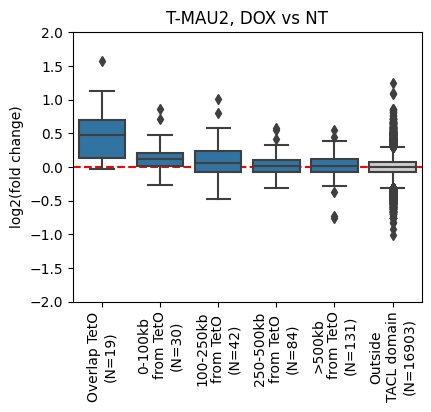

In [22]:
mwu_test_tacl_teto = mannwhitneyu(degs_tmau2_dox_vs_nt[degs_tmau2_dox_vs_nt['gene_id'].isin(genes_tacl_domain_teto)]['log2FoldChange'].values,
                                  degs_tmau2_dox_vs_nt[degs_tmau2_dox_vs_nt['gene_id'].isin(genes_outside_tacl_domain)]['log2FoldChange'].values)
mwu_test_tacl_teto_100kb = mannwhitneyu(degs_tmau2_dox_vs_nt[degs_tmau2_dox_vs_nt['gene_id'].isin(genes_tacl_domain_teto_100kb)]['log2FoldChange'].values,
                                  degs_tmau2_dox_vs_nt[degs_tmau2_dox_vs_nt['gene_id'].isin(genes_outside_tacl_domain)]['log2FoldChange'].values)
mwu_test_tacl_teto_250kb = mannwhitneyu(degs_tmau2_dox_vs_nt[degs_tmau2_dox_vs_nt['gene_id'].isin(genes_tacl_domain_teto_250kb)]['log2FoldChange'].values,
                                  degs_tmau2_dox_vs_nt[degs_tmau2_dox_vs_nt['gene_id'].isin(genes_outside_tacl_domain)]['log2FoldChange'].values)
mwu_test_tacl_teto_500kb = mannwhitneyu(degs_tmau2_dox_vs_nt[degs_tmau2_dox_vs_nt['gene_id'].isin(genes_tacl_domain_teto_500kb)]['log2FoldChange'].values,
                                  degs_tmau2_dox_vs_nt[degs_tmau2_dox_vs_nt['gene_id'].isin(genes_outside_tacl_domain)]['log2FoldChange'].values)
mwu_test_tacl_teto_further = mannwhitneyu(degs_tmau2_dox_vs_nt[degs_tmau2_dox_vs_nt['gene_id'].isin(genes_tacl_domain_teto_further)]['log2FoldChange'].values,
                                  degs_tmau2_dox_vs_nt[degs_tmau2_dox_vs_nt['gene_id'].isin(genes_outside_tacl_domain)]['log2FoldChange'].values)
mwu_fdr = fdrcorrection([mwu_test_tacl_teto[1], mwu_test_tacl_teto_100kb[1], mwu_test_tacl_teto_250kb[1], mwu_test_tacl_teto_500kb[1], mwu_test_tacl_teto_further[1]])

print(f'Genes overlapping TetO vs outside TACL domain: p-value={mwu_test_tacl_teto[1]}, FDR={mwu_fdr[1][0]}')
print(f'Genes 0-100kb from TetO vs outside TACL domain: p-value={mwu_test_tacl_teto_100kb[1]}, FDR={mwu_fdr[1][1]}')
print(f'Genes 100-250kb from TetO vs outside TACL domain: p-value={mwu_test_tacl_teto_250kb[1]}, FDR={mwu_fdr[1][2]}')
print(f'Genes 250-500kb from TetO vs outside TACL domain: p-value={mwu_test_tacl_teto_500kb[1]}, FDR={mwu_fdr[1][3]}')
print(f'Genes >500kb vs outside TACL domain: p-value={mwu_test_tacl_teto_further[1]}, FDR={mwu_fdr[1][4]}')

plt.figure(figsize = (4.5, 3.5))
plt.title('T-MAU2, DOX vs NT')
sns.boxplot(data = [degs_tmau2_dox_vs_nt[degs_tmau2_dox_vs_nt['gene_id'].isin(genes_tacl_domain_teto)]['log2FoldChange'].values,
                    degs_tmau2_dox_vs_nt[degs_tmau2_dox_vs_nt['gene_id'].isin(genes_tacl_domain_teto_100kb)]['log2FoldChange'].values,
                    degs_tmau2_dox_vs_nt[degs_tmau2_dox_vs_nt['gene_id'].isin(genes_tacl_domain_teto_250kb)]['log2FoldChange'].values,
                    degs_tmau2_dox_vs_nt[degs_tmau2_dox_vs_nt['gene_id'].isin(genes_tacl_domain_teto_500kb)]['log2FoldChange'].values,
                    degs_tmau2_dox_vs_nt[degs_tmau2_dox_vs_nt['gene_id'].isin(genes_tacl_domain_teto_further)]['log2FoldChange'].values,
                    degs_tmau2_dox_vs_nt[degs_tmau2_dox_vs_nt['gene_id'].isin(genes_outside_tacl_domain)]['log2FoldChange'].values],
            palette = ['C0', 'C0', 'C0', 'C0', 'C0', '#CCCCCC'])
plt.axhline(0, zorder = -3, color = 'r', ls = '--')
plt.xticks(np.arange(6), ['Overlap TetO\n(N=' + str(len(genes_tacl_domain_teto)) + ')',
                          '0-100kb\nfrom TetO\n(N=' + str(len(genes_tacl_domain_teto_100kb)) + ')',
                    '100-250kb\nfrom TetO\n(N=' + str(len(genes_tacl_domain_teto_250kb)) + ')',
                    '250-500kb\nfrom TetO\n(N=' + str(len(genes_tacl_domain_teto_500kb)) + ')',
                    '>500kb\nfrom TetO\n(N=' + str(len(genes_tacl_domain_teto_further)) + ')',
                    'Outside\nTACL domain\n(N=' + str(len(genes_outside_tacl_domain)) + ')'], rotation = 90)
plt.ylabel('log2(fold change)')
plt.ylim((-2, 2))
plt.savefig('/DATA/users/magnitov/tacl/figures/bruseq_tmau2_genes_tacl_domains.pdf', bbox_inches = 'tight')
plt.show()

Genes overlapping TetO vs outside TACL domain: p-value=0.0001323418686089199, FDR=0.0006617093430445995
Genes 0-100kb from TetO vs outside TACL domain: p-value=0.6035262036872396, FDR=0.7544077546090495
Genes 100-250kb from TetO vs outside TACL domain: p-value=0.066047297332477, FDR=0.1651182433311925
Genes 250-500kb from TetO vs outside TACL domain: p-value=0.1535080022466346, FDR=0.2558466704110577
Genes >500kb vs outside TACL domain: p-value=0.824127923710569, FDR=0.824127923710569


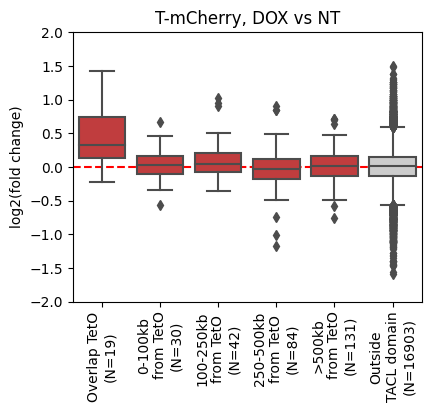

In [23]:
mwu_test_tacl_teto = mannwhitneyu(degs_tmcherry_dox_vs_nt[degs_tmcherry_dox_vs_nt['gene_id'].isin(genes_tacl_domain_teto)]['log2FoldChange'].values,
                                  degs_tmcherry_dox_vs_nt[degs_tmcherry_dox_vs_nt['gene_id'].isin(genes_outside_tacl_domain)]['log2FoldChange'].values)
mwu_test_tacl_teto_100kb = mannwhitneyu(degs_tmcherry_dox_vs_nt[degs_tmcherry_dox_vs_nt['gene_id'].isin(genes_tacl_domain_teto_100kb)]['log2FoldChange'].values,
                                  degs_tmcherry_dox_vs_nt[degs_tmcherry_dox_vs_nt['gene_id'].isin(genes_outside_tacl_domain)]['log2FoldChange'].values)
mwu_test_tacl_teto_250kb = mannwhitneyu(degs_tmcherry_dox_vs_nt[degs_tmcherry_dox_vs_nt['gene_id'].isin(genes_tacl_domain_teto_250kb)]['log2FoldChange'].values,
                                  degs_tmcherry_dox_vs_nt[degs_tmcherry_dox_vs_nt['gene_id'].isin(genes_outside_tacl_domain)]['log2FoldChange'].values)
mwu_test_tacl_teto_500kb = mannwhitneyu(degs_tmcherry_dox_vs_nt[degs_tmcherry_dox_vs_nt['gene_id'].isin(genes_tacl_domain_teto_500kb)]['log2FoldChange'].values,
                                  degs_tmcherry_dox_vs_nt[degs_tmcherry_dox_vs_nt['gene_id'].isin(genes_outside_tacl_domain)]['log2FoldChange'].values)
mwu_test_tacl_teto_further = mannwhitneyu(degs_tmcherry_dox_vs_nt[degs_tmcherry_dox_vs_nt['gene_id'].isin(genes_tacl_domain_teto_further)]['log2FoldChange'].values,
                                  degs_tmcherry_dox_vs_nt[degs_tmcherry_dox_vs_nt['gene_id'].isin(genes_outside_tacl_domain)]['log2FoldChange'].values)
mwu_fdr = fdrcorrection([mwu_test_tacl_teto[1], mwu_test_tacl_teto_100kb[1], mwu_test_tacl_teto_250kb[1], mwu_test_tacl_teto_500kb[1], mwu_test_tacl_teto_further[1]])

print(f'Genes overlapping TetO vs outside TACL domain: p-value={mwu_test_tacl_teto[1]}, FDR={mwu_fdr[1][0]}')
print(f'Genes 0-100kb from TetO vs outside TACL domain: p-value={mwu_test_tacl_teto_100kb[1]}, FDR={mwu_fdr[1][1]}')
print(f'Genes 100-250kb from TetO vs outside TACL domain: p-value={mwu_test_tacl_teto_250kb[1]}, FDR={mwu_fdr[1][2]}')
print(f'Genes 250-500kb from TetO vs outside TACL domain: p-value={mwu_test_tacl_teto_500kb[1]}, FDR={mwu_fdr[1][3]}')
print(f'Genes >500kb vs outside TACL domain: p-value={mwu_test_tacl_teto_further[1]}, FDR={mwu_fdr[1][4]}')

plt.figure(figsize = (4.5, 3.5))
plt.title('T-mCherry, DOX vs NT')
sns.boxplot(data = [degs_tmcherry_dox_vs_nt[degs_tmcherry_dox_vs_nt['gene_id'].isin(genes_tacl_domain_teto)]['log2FoldChange'].values,
                    degs_tmcherry_dox_vs_nt[degs_tmcherry_dox_vs_nt['gene_id'].isin(genes_tacl_domain_teto_100kb)]['log2FoldChange'].values,
                    degs_tmcherry_dox_vs_nt[degs_tmcherry_dox_vs_nt['gene_id'].isin(genes_tacl_domain_teto_250kb)]['log2FoldChange'].values,
                    degs_tmcherry_dox_vs_nt[degs_tmcherry_dox_vs_nt['gene_id'].isin(genes_tacl_domain_teto_500kb)]['log2FoldChange'].values,
                    degs_tmcherry_dox_vs_nt[degs_tmcherry_dox_vs_nt['gene_id'].isin(genes_tacl_domain_teto_further)]['log2FoldChange'].values,
                    degs_tmcherry_dox_vs_nt[degs_tmcherry_dox_vs_nt['gene_id'].isin(genes_outside_tacl_domain)]['log2FoldChange'].values],
            palette = ['C3', 'C3', 'C3', 'C3', 'C3', '#CCCCCC'])
plt.axhline(0, zorder = -3, color = 'r', ls = '--')
plt.xticks(np.arange(6), ['Overlap TetO\n(N=' + str(len(genes_tacl_domain_teto)) + ')',
                          '0-100kb\nfrom TetO\n(N=' + str(len(genes_tacl_domain_teto_100kb)) + ')',
                    '100-250kb\nfrom TetO\n(N=' + str(len(genes_tacl_domain_teto_250kb)) + ')',
                    '250-500kb\nfrom TetO\n(N=' + str(len(genes_tacl_domain_teto_500kb)) + ')',
                    '>500kb\nfrom TetO\n(N=' + str(len(genes_tacl_domain_teto_further)) + ')',
                    'Outside\nTACL domain\n(N=' + str(len(genes_outside_tacl_domain)) + ')'], rotation = 90)
plt.ylabel('log2(fold change)')
plt.ylim((-2, 2))
plt.savefig('/DATA/users/magnitov/tacl/figures/bruseq_tmcherry_genes_tacl_domains.pdf', bbox_inches = 'tight')
plt.show()